In [ ]:
# default_exp data.core

# Data Core

> Main Numpy and Times Series functions used throughout the library.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.external import *
from tsai.data.validation import *

In [ ]:
dsid = 'OliveOil'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)
X_on_disk, y_on_disk, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)
X_in_memory, y_in_memory, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=False, return_split=False)
y_tensor = cat2int(y_on_disk)
y_array = y_tensor.numpy()

Dataset: OliveOil
X_train: (30, 1, 570)
y_train: (30,)
X_valid: (30, 1, 570)
y_valid: (30,) 

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]) 

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]) 



In [ ]:
#export
def _fa_rebuild_tensor (cls, *args, **kwargs): return cls(torch._utils._rebuild_tensor_v2(*args, **kwargs))
def _fa_rebuild_qtensor(cls, *args, **kwargs): return cls(torch._utils._rebuild_qtensor  (*args, **kwargs))

In [ ]:
#hide
#old
class TensorBase2(Tensor):
    def __new__(cls, x, **kwargs):
        res = cast(tensor(x), cls)
        res._meta = kwargs
        return res

    @classmethod
    def _before_cast(cls, x): return x if isinstance(x,Tensor) else tensor(x)

    def __reduce_ex__(self,proto):
        torch.utils.hooks.warn_if_has_hooks(self)
        args = (type(self), self.storage(), self.storage_offset(), tuple(self.size()), self.stride())
        if self.is_quantized: args = args + (self.q_scale(), self.q_zero_point())
        f = _fa_rebuild_qtensor if self.is_quantized else  _fa_rebuild_tensor
        return (f, args + (self.requires_grad, OrderedDict()))

    def gi(self, i):
        res = self[i]
        return res.as_subclass(type(self)) if isinstance(res,Tensor) else res

    def __repr__(self):
        return re.sub('tensor', self.__class__.__name__, super().__repr__())

In [ ]:
inp = TensorBase(torch.tensor(5.)).requires_grad_(True)
# inp = torch.tensor(5.).requires_grad_(True) # This is OK
print(inp)
out = inp**2
grad = torch.autograd.grad(out, inp, only_inputs=True)[0]
print(grad)

TensorBase(5., grad_fn=<AliasBackward>)
TensorBase(10.)


In [ ]:
true_img = TensorBase(torch.randn(2, 3, 16)) # get from Dataloaders
# true_img = torch.randn(2, 3, 16) # This is OK
w = torch.tensor(3., requires_grad=True)
fake_img = torch.randn(2, 3, 16) * w # generate from model
def loss_func(fake_img, true_img): return ((fake_img-true_img)**2).mean()
loss = loss_func(fake_img, true_img)
loss.backward()
w.grad

tensor(6.1019)

In [ ]:
# hide
# class NumpyTensor(Tensor): # Temporarily until the issue with require_grad is fixed! TensorBase
#     "Returns a `tensor` with subclass `NumpyTensor` that has a show method"

#     def __new__(cls, o, **kwargs):
#         if isinstance(o, (list, L)): o = stack(o)
#         res = cast(tensor(o), cls)
#         res._meta = kwargs
#         return res

#     def __getitem__(self, idx):
#         res = super().__getitem__(idx)
#         return res.as_subclass(type(self))

#     def __repr__(self):
#         if self.numel() == 1: return f'{self}'
#         else: return f'NumpyTensor(shape:{list(self.shape)})'

#     def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
#         if self.ndim != 2: self = type(self)(to2d(self))
#         self = self.detach().cpu().numpy()
#         ax = ifnone(ax, ctx)
#         if ax is None: fig, ax = plt.subplots(**kwargs)
#         ax.plot(self.T)
#         ax.axis(xmin=0, xmax=self.shape[-1] - 1)
#         ax.set_title(title, weight='bold', color=title_color)
#         plt.tight_layout()
#         return ax


# class ToNumpyTensor(Transform):
#     "Transforms an object into NumpyTensor"
#     def encodes(self, o): return NumpyTensor(o)

In [ ]:
#export
class NumpyTensor(TensorBase):
    "Returns a `tensor` with subclass `NumpyTensor` that has a show method"

    def __new__(cls, o, **kwargs):
        if isinstance(o, (list, L)): o = stack(o)
        res = cast(tensor(o), cls)
        res._meta = kwargs
        return res

    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return res.as_subclass(type(self))

    def __repr__(self):
        if self.numel() == 1: return f'{self}'
        else: return f'NumpyTensor(shape:{tuple(self.shape)})'

    def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
        if self.ndim != 2: self = type(self)(to2d(self))
        self = self.detach().cpu().numpy()
        ax = ifnone(ax, ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax


class ToNumpyTensor(Transform):
    "Transforms an object into NumpyTensor"
    def encodes(self, o): return NumpyTensor(o)

In [ ]:
#export
class TSTensor(NumpyTensor):
    '''Returns a `tensor` with subclass `TSTensor` that has a show method'''
    @property
    def vars(self): return self.shape[1]

    @property
    def len(self): return self.shape[-1]

    def __repr__(self):
        if self.numel() == 1: return f'{self}'
        elif self.ndim >= 3:
            return f'TSTensor(samples:{self.shape[0]}, vars:{self.shape[1]}, len:{self.shape[-1]})'
        elif self.ndim == 2:
            return f'TSTensor(vars:{self.shape[1]}, len:{self.shape[-1]})'
        elif self.ndim == 1:
            return f'TSTensor(len:{self.shape[-1]})'


class ToTSTensor(Transform):
    "Transforms an object into TSTensor"
    def encodes(self, o): return TSTensor(o)

In [ ]:
# https://github.com/fastai/fastai/issues/278
true = TSTensor(torch.randn(2, 3, 4))
w = torch.tensor(3., requires_grad=True)
fake = torch.randn(2, 3, 4) * w  # generated by model


def loss_func(fake, true):
    return ((fake - true)**2).mean()


loss = loss_func(fake, true)
loss.backward()
w.grad

tensor(7.2446)

In [ ]:
t = TSTensor(torch.randn(2, 3, 4))
p = torch.tensor(3., requires_grad=True)
test = torch.add(true, p)
test_eq(test.requires_grad, True)

In [ ]:
l = L([0,1,2,3], [4,5,6,7], [8, 9, 10, 11])
TSTensor(l)

TSTensor(vars:4, len:4)

In [ ]:
t = TSTensor(X_train)
for i in range(4):
    print(t)
    if i < 3: t = t[0]

TSTensor(samples:30, vars:1, len:570)
TSTensor(vars:570, len:570)
TSTensor(len:570)
-0.6113752722740173


In [ ]:
TSTensor(X_on_disk)

TSTensor(samples:60, vars:1, len:570)

In [ ]:
ToTSTensor()(X_on_disk)

TSTensor(samples:60, vars:1, len:570)

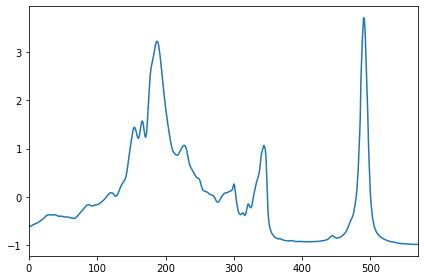

In [ ]:
TSTensor(X_train).show();

In [ ]:
#export
class ToFloat(Transform):
    "Transforms an object dtype to float"
    def encodes(self, o:torch.Tensor): return o.float()
    def encodes(self, o): return o.astype(np.float32)
    
    
class ToInt(Transform):
    "Transforms an object dtype to int"
    def encodes(self, o:torch.Tensor): return o.long()
    def encodes(self, o): return o.astype(np.float32).astype(np.int64)

In [ ]:
a = np.random.randint(0, 2, 10)
b = np.array(['1', '2', '3'])
c = np.array(['1.0', '2.0', '3.0'])
t = torch.randint(0, 2, (10, ))
test_eq(ToFloat()(a).dtype, 'float32')
test_eq(ToFloat()(b).dtype, 'float32')
test_eq(ToFloat()(c).dtype, 'float32')
test_eq(ToFloat()(t).dtype, torch.float32)

In [ ]:
a = np.random.rand(10)*10
b = np.array(['1.0', '2.0', '3.0'])
t = torch.rand(10)*10
test_eq(ToInt()(a).dtype, 'int64')
test_eq(ToInt()(b).dtype, 'int64')
test_eq(ToInt()(t).dtype, torch.long)

In [ ]:
#export
class NumpyTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =                 L(type_tfms)
        self.item_tfms  = ToNumpyTensor + L(item_tfms)
        self.batch_tfms =                 L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
        
class TSTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =              L(type_tfms)
        self.item_tfms  = ToTSTensor + L(item_tfms)
        self.batch_tfms =              L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [ ]:
test_eq(NumpyTensorBlock().item_tfms[0].__name__, 'ToNumpyTensor')
test_eq(TSTensorBlock().item_tfms[0].__name__, 'ToTSTensor')

In [ ]:
#export
class TorchDataset():
    def __init__(self, X, y=None): self.X, self.y = X, y
    def __getitem__(self, idx): return (self.X[idx],) if self.y is None else (self.X[idx], self.y[idx])
    def __len__(self): return len(self.X)

    
class NumpyDataset():
    def __init__(self, X, y=None, types=None): self.X, self.y, self.types = X, y, types
    def __getitem__(self, idx): 
        if self.types is None: return (self.X[idx], self.y[idx]) if self.y is not None else (self.X[idx])
        else: return (self.types[0](self.X[idx]), self.types[1](self.y[idx])) if self.y is not None else (self.types[0](self.X[idx]))
    def __len__(self): return len(self.X)
    @property
    def c(self): return 0 if self.y is None else 1 if isinstance(self.y[0], float) else len(np.unique(self.y)) 

    
class TSDataset():
    def __init__(self, X, y=None, types=None, sel_vars=None, sel_steps=None): 
        self.X, self.y, self.types = to3darray(X), y, types
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
    def __getitem__(self, idx): 
        if self.types is None: return (self.X[idx, self.sel_vars, self.sel_steps], self.y[idx]) if self.y is not None else (self.X[idx])
        else: 
            return (self.types[0](self.X[idx, self.sel_vars, self.sel_steps]), self.types[1](self.y[idx])) if self.y is not None \
            else (self.types[0](self.X[idx]))
    def __len__(self): return len(self.X)
    @property
    def c(self): return 0 if self.y is None else 1 if isinstance(self.y[0], float) else len(np.unique(self.y)) 
    @property
    def vars(self): return self[0][0].shape[0]
    @property
    def len(self): return self[0][0].shape[-1]

In [ ]:
a = np.random.rand(5,6,7)
b = np.random.rand(5)
ds = NumpyDataset(a,b)
xb, yb = ds[[0,4]]
test_eq(xb.shape, (2,6,7))
test_eq(yb.shape, (2,))
test_eq(ds.c, 1)

In [ ]:
a = np.random.rand(5,6,7)
b = np.random.randint(0, 2, 5)
ds = TSDataset(a,b)
test_eq(ds.c, len(np.unique(b)))
test_eq(ds.vars, 6)
test_eq(ds.len, 7)

In [ ]:
#old
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `tfms` of type item_tfms"
    _xtype, _ytype = NumpyTensor, None # Expected X and y output types (must have a show method)
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, inplace=True, **kwargs):
        self.inplace = inplace
        if tls is None: 
            X = itemify(X, tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if len(self.tls[0]) > 0: 
            # type(tl[0]).__name__ == 'memmap' is added to avoid loading in memory larger than RAM datasets
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else tensor(tl[:]) for tl in self.tls])
            self.types = [ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for tl,_typ in zip(self.tls, [self._xtype, self._ytype])]
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it] if i==0 else ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, inplace=self.inplace, tfms=self.tfms)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = ifnoneelse(y,tuple((X)),tuple((X, y)))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    def show_at(self, idx, **kwargs):
        self.show(self[idx], **kwargs)
        plt.show()

    @property
    def items(self): return tuple([tl.items for tl in self.tls])
    @items.setter
    def items(self, vs):
        for tl,c in zip(self.tls, vs): tl.items = v


class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 inplace=True, **kwargs):
        self.inplace = inplace
        if tls is None: 
            X = itemify(X, tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if len(self.tls[0]) > 0: 
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else tensor(tl[:]) for tl in self.tls])
            self.types = [ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for tl,_typ in zip(self.tls, [self._xtype, self._ytype])]
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           inplace=self.inplace, tfms=self.tfms, sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    @property
    def vars(self): return self[0][0].shape[-2]
    @property
    def len(self): return self[0][0].shape[-1]

In [ ]:
#export
@delegates(Datasets.__init__)
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `tfms` of type item_tfms"
    _xtype, _ytype = NumpyTensor, None # Expected X and y output types (must have a show method)
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, inplace=True, **kwargs):
        self.inplace = inplace
        if tls is None: 
            X = itemify(X, tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if 'split' in kwargs: self.split_idxs = kwargs['split']
        elif 'splits' in kwargs:  self.split_idxs = kwargs['splits']
        else: self.split_idxs = L(np.arange(len(self.tls[0]) if len(self.tls[0]) > 0 else len(self.tls)).tolist())
        if len(self.tls[0]) > 0: 
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for tl,_typ in zip(self.tls, [self._xtype, self._ytype])])
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else tensor(stack(tl[:])) for tl in self.tls])
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, inplace=self.inplace, tfms=self.tfms,
                                          split=L(self.splits[i]) if self.splits is not None else None)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = tuple((X,)) if y is None else tuple((X, y))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    def show_at(self, idx, **kwargs):
        self.show(self[idx], **kwargs)
        plt.show()

    @property
    def items(self): return tuple([tl.items for tl in self.tls])
    @items.setter
    def items(self, vs):
        for tl,c in zip(self.tls, vs): tl.items = v
    @property
    def c(self): 
        return 0 if len(self.tls) == 1 else 1 if isinstance(self.ptls[1][0].item(), float) else len(np.unique(self.ptls[1])) 
    @property
    def loss_func(self): 
        return MSELossFlat() if self.c == 1 else CrossEntropyLossFlat()


@delegates(NumpyDatasets.__init__)
class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 inplace=True, **kwargs):
        self.inplace = inplace
        if tls is None: 
            X = itemify(to3darray(X), tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if 'split' in kwargs: self.split_idxs = kwargs['split']
        elif 'splits' in kwargs:  self.split_idxs = kwargs['splits']
        else: self.split_idxs = L(np.arange(len(self.tls[0]) if len(self.tls[0]) > 0 else len(self.tls)).tolist())
        if len(self.tls[0]) > 0: 
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for tl,_typ in zip(self.tls, [self._xtype, self._ytype])])
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else tensor(stack(tl[:])) for tl in self.tls])
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])

    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, inplace=self.inplace, tfms=self.tfms, 
                                           sel_vars=self.sel_vars, sel_steps=self.sel_steps, split=L(self.splits[i]) if self.splits is not None else None)
    @property
    def vars(self): return self[0][0].shape[0]
    @property
    def len(self): return self[0][0].shape[-1]

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=False)
dsets2 = TSDatasets(X_on_disk[:, 0], y_array, tfms=None, splits=splits, inplace=True)
test_eq_type(dsets[0][0].data, dsets2[0][0].data)

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=False)
test_eq(len(dsets.train), len(X_train))
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=True)
test_eq(len(dsets.train), len(X_train))
dsets = TSDatasets(X_on_disk, y_array, tfms=[add(1), Categorize()], splits=splits, inplace=True)
test_eq(len(dsets.train), len(X_train))
test_eq(dsets.train[0][0].data, tensor(X_train[0] + 1))
test_eq(dsets.train[0][1].data, y_tensor[0])

In [ ]:
#export
def add_ds(dsets, X, y=None, inplace=True):
    "Create test datasets from X (and y) using validation transforms of `dsets`"
    items = tuple((X,)) if y is None else tuple((X, y))
    with_labels = False if y is None else True
    if isinstance(dsets, (Datasets, NumpyDatasets, TSDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        if isinstance(dsets, TSDatasets):
            return TSDatasets(tls=new_tls, n_inp=dsets.n_inp, inplace=inplace, tfms=dsets.tfms,
                              sel_vars=dsets.sel_vars, sel_steps=dsets.sel_steps)
        elif isinstance(dsets, NumpyDatasets):
            return NumpyDatasets(tls=new_tls, n_inp=dsets.n_inp, inplace=inplace, tfms=dsets.tfms)
        elif isinstance(dsets, Datasets): return Datasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

@patch
def add_dataset(self:NumpyDatasets, X, y=None, inplace=True):
    return add_ds(self, X, y=y, inplace=inplace)

@patch
def add_test(self:NumpyDatasets, X, y=None, inplace=True):
    return add_ds(self, X, y=y, inplace=inplace)

@patch
def add_unlabeled(self:NumpyDatasets, X, inplace=True):
    return add_ds(self, X, y=None, inplace=inplace)

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=[None, Categorize()], splits=splits, inplace=True)
test_eq(len(dsets.add_test(X_train, y_train)), len(X_train))
test_eq(len(dsets.add_unlabeled(X_train)), len(X_train))

In [ ]:
#export
_batch_tfms = ('after_item','before_batch','after_batch')

@delegates(TfmdDL.__init__)
class NumpyDataLoader(TfmdDL):
    idxs = None
    do_item = noops # create batch returns indices
    def __init__(self, dataset, bs=64, shuffle=True, drop_last=True, num_workers=None, verbose=False, do_setup=True, batch_tfms=None, **kwargs):
        '''batch_tfms == after_batch (either can be used)'''
        if num_workers is None: num_workers = min(16, defaults.cpus)
        for nm in _batch_tfms: 
            if nm == 'after_batch':
                if batch_tfms is not None: kwargs[nm] = Pipeline(batch_tfms if isinstance(batch_tfms, list) else [batch_tfms])
                else: kwargs[nm] = Pipeline(kwargs.get(nm,None))
            else: kwargs[nm] = Pipeline(kwargs.get(nm,None))
        bs = min(bs, len(dataset))
        super().__init__(dataset, bs=bs, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers, **kwargs)
        if do_setup:
            for nm in _batch_tfms:
                pv(f"Setting up {nm}: {kwargs[nm]}", verbose)
                kwargs[nm].setup(self)

    def create_batch(self, b):
        it = b if self.shuffle else slice(b[0], b[0] + self.bs)
        self.idxs = b
        if hasattr(self, "split_idxs"): self.input_idxs = self.split_idxs[it]
        return self.dataset[it]

    def create_item(self, s): return s

    def get_idxs(self):
        idxs = Inf.count if self.indexed else Inf.nones
        if self.n is not None: idxs = list(range(len(self.dataset)))
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs
    
    def unique_batch(self, max_n=9):
        old_bs = self.bs
        self.bs = 1
        old_get_idxs = self.get_idxs
        self.get_idxs = lambda: Inf.zeros
        out_len = len(self.items)
        types = self.dataset.types
        x, y = [], []
        for _ in range(max_n): 
            out = self.one_batch()
            if out_len == 2: 
                x.extend(out[0])
                y.extend(out[1])
            else: 
                x.extend(out)
        b = (types[0](stack(x)), types[1](stack(y))) if out_len == 2 else (types[0](stack(x)), )
        self.bs = old_bs
        self.get_idxs = old_get_idxs
        return b


    @delegates(plt.subplots)
    def show_batch(self, b=None, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), unique=False, **kwargs):
        if unique: b = self.unique_batch(max_n=max_n)
        elif b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(db), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs): show_tuple(db[i], ctx=ctx)


    @delegates(plt.subplots)
    def show_results(self, b, preds, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        t = self.decode_batch(b, max_n=max_n)
        p = self.decode_batch((b[0],preds), max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(t), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs): 
            title = f'True: {t[i][1]}\nPred: {p[i][1]}'
            color = 'green' if t[i][1] == p[i][1] else 'red'
            t[i][0].show(ctx=ctx, title=title, title_color=color)
            
    @property
    def c(self): return self.dataset.c 

    
@delegates(plt.subplots)
def show_tuple(tup, **kwargs):
    "Display a timeseries plot from a decoded tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], **kwargs)
    
class TSDataLoader(NumpyDataLoader): 
    @property
    def vars(self): 
        b = self.one_batch()
        x = b[0] if isinstance(b, tuple) else b
        return x.shape[1]
    @property
    def len(self): return self.dataset[0][0].shape[-1]

In [ ]:
#export
_batch_tfms = ('after_item','before_batch','after_batch')

class NumpyDataLoaders(DataLoaders):
    _xblock = NumpyTensorBlock
    _dl_type = NumpyDataLoader 
    def __init__(self, *loaders, path='.', device=default_device()):
        self.loaders,self.path = list(loaders),Path(path)
        self.device = device
        
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(cls._xblock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

    @classmethod
    def from_dsets(cls, *ds, path='.', bs=64, num_workers=0, batch_tfms=None, device=default_device(), shuffle_train=True, **kwargs):
        if batch_tfms is not None and not isinstance(batch_tfms, list): batch_tfms = [batch_tfms]
        default = (shuffle_train,) + (False,) * (len(ds)-1)
        defaults = {'shuffle': default, 'drop_last': default}
        kwargs = merge(defaults, {k: tuplify(v, match=ds) for k,v in kwargs.items()})
        kwargs = [{k: v[i] for k,v in kwargs.items()} for i in range_of(ds)]
        if not is_listy(bs): bs = [bs]
        if len(bs) != len(ds): bs = bs * len(ds)
        return cls(*[cls._dl_type(d, bs=b, num_workers=num_workers, batch_tfms=batch_tfms, **k) \
                     for d,k,b in zip(ds, kwargs, bs)], path=path, device=device)

class TSDataLoaders(NumpyDataLoaders):
    _xblock = TSTensorBlock
    _dl_type = TSDataLoader

In [ ]:
#export
@patch
def cws(self:NumpyDataLoader):
    if isinstance(tensor(self.dataset[0][-1]).item(), Integral):
        target = torch.Tensor(self.dataset.items[-1]).to(dtype=torch.int64)
        # Compute samples weight (each sample should get its own weight)
        class_sample_count = torch.tensor([(target == t).sum() for t in torch.unique(target, sorted=True)])
        weights = 1. / class_sample_count.float()
        return (weights / weights.sum()).to(default_device())
    else: return None

In [ ]:
bs = 25
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2], batch_tfms=add(1))
xb,yb = dls.train.one_batch()
test_eq(xb.data, tensor(X_on_disk[splits[0]][dls.train.idxs]) + 1)
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
xb,yb = dls.train.one_batch()
test_eq(xb.shape, (min(bs, len(splits[0])), X_on_disk.shape[1], X_on_disk.shape[-1]))
for xb,yb in dls.train: 
    test_eq(xb.data, tensor(X_on_disk[splits[0]][dls.train.idxs]))
it = iter(dls.train)
for _ in range(len(dls.train)):
    xb,yb = next(it)
    test_eq(xb.data, tensor(X_on_disk[dls.train.idxs]))

In [ ]:
bs = 64
dsets = TSDatasets(X_on_disk, y_array, tfms=[add(1), Categorize()], splits=RandomSplitter(valid_pct=.3)(y_array), inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
xb,yb = dls.train.one_batch()
test_eq(xb.shape, (min(bs, len(dsets.train)), X_on_disk.shape[1], X_on_disk.shape[-1]))
xb,yb = dls.valid.one_batch()
test_eq(xb.shape, (min(bs*2, len(dsets.valid)), X_on_disk.shape[1], X_on_disk.shape[-1]))

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[32, 64])
for i in range(100):
    dl = dls.train if random.random() < .5 else dls.valid
    xb,yb = dl.one_batch()
    torch.equal(xb, TSTensor(X_on_disk[dl.input_idxs]))
    
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], inplace=True)
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
for i in range(100):
    xb,yb = dls.one_batch()
    torch.equal(xb, TSTensor(X_on_disk[dl.input_idxs]))
    
dsets = TSDatasets(X_on_disk, tfms=None, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
for i in range(100):
    xb = dls.one_batch()
    torch.equal(xb[0], TSTensor(X_on_disk[dl.input_idxs]))

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], inplace=True)
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
test_eq_type(dls.split_idxs, L(np.arange(len(X_on_disk)).tolist()))

In [ ]:
dsid = 'NATOPS' 
bs = 64
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [ ]:
dsid = 'NATOPS' 
bs = 64
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=False)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.transforms.ipynb.
Converted 003b_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.FCN.ipynb.
Converted 103b_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.RNN.ipynb.
Converted 105_models.RNNPlus.ipynb.
Converted 106_models.XceptionTime.ipynb.
Converted 106b_models.XceptionTimePlus.ipynb.
Converted 107_models.RNN_FCN.ipynb.
Converted 107b_models.RNN_FCNPlus.ipynb.
Converted 108_models.TransformerModel.ipynb.